1) denoising auto encoder

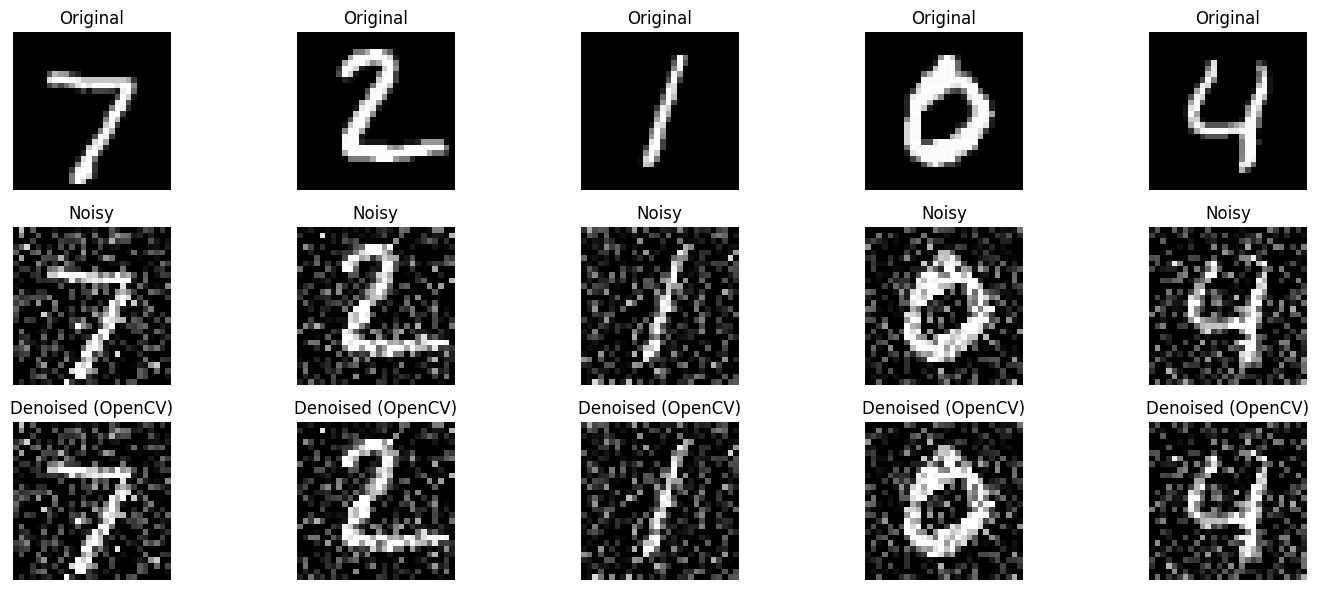

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import cv2

# Step 1: Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize the images to [0, 1] range
x_train = x_train / 255.0
x_test = x_test / 255.0

# Step 2: Add Gaussian noise to the images (simulating noisy data)
def add_noise(img, noise_factor=0.3):
    """
    Adds Gaussian noise to an image.
    :param img: The image to add noise to.
    :param noise_factor: The intensity of the noise.
    :return: The noisy image.
    """
    noisy_img = img + noise_factor * np.random.randn(*img.shape)
    noisy_img = np.clip(noisy_img, 0.0, 1.0)  # Keep pixel values in [0, 1]
    return noisy_img

# Add noise to a subset of images for demonstration
noisy_images = np.array([add_noise(img) for img in x_test[:5]])

# Step 3: Denoising using OpenCV - Non-Local Means Denoising (color images converted to grayscale)
def denoise_image_opencv(image):
    """
    Denoises an image using OpenCV's Non-Local Means Denoising.
    :param image: The noisy image to denoise.
    :return: The denoised image.
    """
    # Convert the image to uint8 (required by OpenCV)
    image_uint8 = np.uint8(image * 255)
    denoised_image = cv2.fastNlMeansDenoising(image_uint8, None, 10, 7, 21)
    # Normalize back to [0, 1]
    return denoised_image / 255.0

# Denoising the noisy images
denoised_images_opencv = np.array([denoise_image_opencv(img) for img in noisy_images])

# Step 4: Plotting the original, noisy, and denoised images step by step
fig, axes = plt.subplots(3, 5, figsize=(15, 6))

for i in range(5):
    # Original images (from x_test)
    axes[0, i].imshow(x_test[i], cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')

    # Noisy images
    axes[1, i].imshow(noisy_images[i], cmap='gray')
    axes[1, i].set_title("Noisy")
    axes[1, i].axis('off')

    # Denoised images using OpenCV
    axes[2, i].imshow(denoised_images_opencv[i], cmap='gray')
    axes[2, i].set_title("Denoised (OpenCV)")
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()


2) veriance auto encoder

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 91s 185ms/step - loss: 249.8489 - val_loss: 167.7922
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 183ms/step - loss: 162.9947 - val_loss: 156.9436
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 145s 190ms/step - loss: 154.9138 - val_loss: 151.6418
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 140s 186ms/step - loss: 150.6694 - val_loss: 150.6841
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 185ms/step - loss: 148.7607 - val_loss: 148.6256
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 184ms/step - loss: 146.9741 - val_loss: 146.2627
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 140s 181ms/step - loss: 146.2084 - val_loss: 145.7486
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 182ms/step - loss: 144.9383 - val_loss: 144.8130
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 183ms/step - loss: 144.3029 - val_loss: 144.7783
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 177ms/step - loss: 143.3892 - val_loss: 143.8941
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


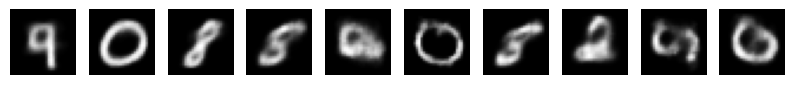

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras.losses import binary_crossentropy

# Load and preprocess MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

# Latent dimension (size of latent space)
latent_dim = 2

# Encoder
inputs = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

# Mean and log variance for the latent space
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

# Reparameterization trick to sample z
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

# Instantiate encoder and decoder models
encoder = Model(inputs, [z_mean, z_log_var, z])
decoder = Model(latent_inputs, outputs)

# VAE Model
vae_output = decoder(encoder(inputs)[2])  # Get the latent space z and decode it
vae = Model(inputs, vae_output)

# VAE Loss Calculation inside the Model's `call()` method
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        outputs = self.decoder(z)

        # Reconstruction loss (binary crossentropy)
        reconstruction_loss = binary_crossentropy(inputs, outputs)
        reconstruction_loss *= 28 * 28  # Scale to match input size

        # KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )

        # Total VAE loss
        total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

        # Add total loss to the model's loss (this will be minimized during training)
        self.add_loss(total_loss)

        return outputs

# Instantiate the VAE model
vae_model = VAE(encoder, decoder)

# Compile the VAE model
vae_model.compile(optimizer='adam')

# Train the VAE
vae_model.fit(x_train, epochs=10, batch_size=128, validation_data=(x_test, None))

# Generate images from the latent space (sampling from a normal distribution)
def generate_images():
    # Sample from the latent space (standard normal distribution)
    random_latent_vectors = np.random.normal(size=(10, latent_dim))
    generated_images = decoder.predict(random_latent_vectors)

    # Plot the generated images
    plt.figure(figsize=(10, 1))
    for i in range(10):
        ax = plt.subplot(1, 10, i + 1)
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Generate images after training
generate_images()
